In [1]:
from pathlib import Path
import os

# Establece la raíz del proyecto manualmente
project_root = Path("F:/JCMDataCenter/Cursos/Evolve Academy/Data Scientist IA/Futpeak") # sobremesa
#project_root = Path("C:/Users/juanm/Desktop/FUTPEAK/Futpeak") # portátil

# Cambia el directorio de trabajo actual a esa raíz
os.chdir(project_root)

print("📁 Directorio de trabajo actual:", Path.cwd())

📁 Directorio de trabajo actual: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Futpeak


# ETAPA 1 — Carga y exploración de los datos

En esta primera etapa, cargamos los archivos `matchlogs` y `metadata`, que contienen información por partido y por jugador, respectivamente.

Nuestro objetivo aquí no es solo cargar los datos, sino **entender qué columnas hay, qué tipo de variables contiene cada una, y cuáles vamos a usar o descartar**.

### ¿Qué buscamos al explorar?
- Qué columnas tienen valores nulos
- Qué columnas son categóricas, numéricas o de fecha
- Si hay identificadores únicos (`Player_ID`)
- Qué variables nos pueden servir para el modelo

Vamos a centrarnos en **variables relacionadas con el rendimiento en el campo**, y **descartar muchas otras que no aportan directamente al objetivo de predecir la evolución del jugador**.



In [2]:
import pandas as pd

# Load datasets
df_matchlogs = pd.read_csv("data/processed/cleaned_matchlogs.csv")
df_metadata = pd.read_csv("data/processed/cleaned_metadata.csv")

# Show general info for structure
print("🔍 Matchlogs structure:")
df_matchlogs.info()

print("\n🧾 Metadata structure:")
df_metadata.info()

# Preview a few rows
df_matchlogs.head()


🔍 Matchlogs structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368257 entries, 0 to 368256
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Player_name            368257 non-null  object 
 1   Player_ID              368257 non-null  object 
 2   Seasons                368257 non-null  object 
 3   Date                   368257 non-null  object 
 4   Day                    368257 non-null  object 
 5   Competition            368257 non-null  object 
 6   Round                  368257 non-null  object 
 7   Home_Away              368257 non-null  object 
 8   Result                 368257 non-null  object 
 9   Player_team            368257 non-null  object 
 10  Rival_team             368257 non-null  object 
 11  Start                  368257 non-null  object 
 12  Position               283886 non-null  object 
 13  Minutes                367852 non-null  float64
 14  Goals        

,Player_name,Player_ID,Seasons,Date,Day,Competition,Round,Home_Away,Result,Player_team,...,x_assisted_G,Shot_creating_actions,Goal_creating_actions,Passes_completed,Passes_att,Percent_passes,Progressive_passes,Feet_control,Progressive_control,Dribling_suc
0,Luciano Abecasis,6c510f2d,2016,2016-02-05,Fri,Primera Div,Matchweek 1,Away,L 0–1,Godoy Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Luciano Abecasis,6c510f2d,2016,2016-02-12,Fri,Primera Div,Matchweek 2,Home,D 1–1,Godoy Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Luciano Abecasis,6c510f2d,2016,2016-02-18,Thu,Primera Div,Matchweek 3,Away,W 2–1,Godoy Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Luciano Abecasis,6c510f2d,2016,2016-02-21,Sun,Primera Div,Matchweek 4,Home,W 4–1,Godoy Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Luciano Abecasis,6c510f2d,2016,2016-02-26,Fri,Primera Div,Matchweek 5,Away,W 3–2,Godoy Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# View all columns in matchlogs
print("🔧 All columns in matchlogs:")
print(df_matchlogs.columns.tolist())

# List of columns we plan to keep
columns_to_use = [
    'Player_ID', 'Date', 'Minutes', 'Goals', 'Assists',
    'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards'
]

print("\n✅ Columns selected for modeling:")
print(columns_to_use)

# Optional: create a reduced version of the matchlogs
df_matchlogs = df_matchlogs[columns_to_use]



🔧 All columns in matchlogs:
['Player_name', 'Player_ID', 'Seasons', 'Date', 'Day', 'Competition', 'Round', 'Home_Away', 'Result', 'Player_team', 'Rival_team', 'Start', 'Position', 'Minutes', 'Goals', 'Assists', 'Penalty_kick', 'Penalty_kick_att', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Fouls_committed', 'Fouls_drawn', 'Offsides', 'Crosses', 'Tackles_won', 'Interceptions', 'Own_goals', 'Penaltys_won', 'Penaltys_conceded', 'Touches', 'Tackles', 'Blocks', 'xG', 'non_penalty_xG', 'x_assisted_G', 'Shot_creating_actions', 'Goal_creating_actions', 'Passes_completed', 'Passes_att', 'Percent_passes', 'Progressive_passes', 'Feet_control', 'Progressive_control', 'Dribling_suc']

✅ Columns selected for modeling:
['Player_ID', 'Date', 'Minutes', 'Goals', 'Assists', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards']


# ETAPA 2 — Filtrado de jugadores ofensivos y cálculo del debut

No todos los jugadores tienen el mismo tipo de rendimiento ni las mismas estadísticas.  
En este proyecto, **nos centramos en jugadores ofensivos y mediocampistas**, porque son los que aportan goles, asistencias y tiros (las métricas que usaremos para valorar el rendimiento).

Además, para poder analizar la progresión desde el inicio de la carrera, necesitamos:
- Detectar el **primer partido profesional (debut)**.
- Calcular desde entonces en qué año de carrera está cada jugador en cada partido.

También calcularemos la edad del jugador en cada partido, porque **la edad es una variable predictiva clave** para el tipo de evolución que tendrá.


In [4]:
POSITION_GROUPS = {
    'GOALKEEPER': ['GK'],

    'DEFENSIVE': [
        'CB',    # Center Back
        'LB',    # Left Back
        'RB',    # Right Back
        'FB',    # Fullback
        'LWB',   # Left Wing Back
        'RWB',   # Right Wing Back
        'SW',    # Sweeper
        'D'      # Generic Defender
    ],

    'MIDFIELD': [
        'CM',    # Center Midfielder
        'DM',    # Defensive Midfielder
        'MF',     # Generic Midfielder
        'AM'     # Attacking Midfielder (can also be attacking, but here consider control of juego)
    ],

    'ATTACKING': [
        'CF',    # Center Forward
        'ST',    # Striker
        'F',     # Generic Forward
        'FW',    # Forward (alternative code)
        'LW',    # Left Wing
        'RW',    # Right Wing
        'WF',    # Wing Forward
        'IF',    # Inside Forward
        'OL',    # Outside Left
        'OR'     # Outside Right
    ]
}


In [5]:
# Define relevant positions for attacking/midfield players
target_positions = POSITION_GROUPS['MIDFIELD'] + POSITION_GROUPS['ATTACKING']

# Create a function to check if position is relevant
def is_target_position(pos):
    if pd.isna(pos):
        return False
    return any(p in pos.split('-') for p in target_positions)

# Filter metadata to only include target players
df_metadata['Is_Target'] = df_metadata['Position'].apply(is_target_position)
df_metadata_target = df_metadata[df_metadata['Is_Target']]

# Filter matchlogs for selected players
target_ids = df_metadata_target['Player_ID'].unique()
df_matchlogs_target = df_matchlogs[df_matchlogs['Player_ID'].isin(target_ids)].copy()


In [6]:
# Convert Date columns to datetime
df_matchlogs_target['Date'] = pd.to_datetime(df_matchlogs_target['Date'], errors='coerce')
df_metadata['Birth_date'] = pd.to_datetime(df_metadata['Birth_date'], errors='coerce')

# Merge Birth_date into matchlogs
df_matchlogs_target = df_matchlogs_target.merge(
    df_metadata[['Player_ID', 'Birth_date']],
    on='Player_ID', how='left'
)

# Calcular debut por jugador (primer partido con minutos > 0)
debut_dates = df_matchlogs_target[df_matchlogs_target['Minutes'] > 0].groupby('Player_ID')['Date'].min()
df_matchlogs_target['Debut_date'] = df_matchlogs_target['Player_ID'].map(debut_dates)

# Calcular año relativo desde el debut
df_matchlogs_target['year_since_debut'] = (
    (df_matchlogs_target['Date'] - df_matchlogs_target['Debut_date']).dt.days // 365 + 1
)

# Calcular edad en el partido
df_matchlogs_target['age'] = (
    (df_matchlogs_target['Date'] - df_matchlogs_target['Birth_date']).dt.days / 365.25
)


# ETAPA 3 — Cálculo del rendimiento ofensivo por partido

Queremos transformar las estadísticas individuales (goles, asistencias, tiros, tarjetas...) en **una única métrica de rendimiento**.  
Esta métrica nos permitirá comparar partidos entre sí de manera más objetiva.

Además, vamos a normalizar esta métrica por 90 minutos.  
¿Por qué? Porque jugar 15 minutos y marcar un gol no equivale a jugar 90 y marcar uno. **Necesitamos ajustar el rendimiento al tiempo jugado.**

### Fórmula propuesta:
- +5 por cada gol
- +4 por asistencia
- +0.5 por tiro a puerta
- +0.1 por tiro fuera
- -1 por amarilla
- -2 por roja

El resultado se divide por los minutos jugados y se multiplica por 90 → rendimiento por 90 minutos.


In [7]:
# Fill missing values with 0
cols = ['Goals', 'Assists', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Minutes']
df_matchlogs_target[cols] = df_matchlogs_target[cols].fillna(0)

# Function to compute performance rating
def calculate_rating(row):
    score = (
        row['Goals'] * 5 +
        row['Assists'] * 4 +
        row['Shots_on_target'] * 0.5 +
        (row['Shots'] - row['Shots_on_target']) * 0.1 -
        row['Yellow_cards'] * 1 -
        row['Red_cards'] * 2
    )
    return score / (row['Minutes'] / 90) if row['Minutes'] > 0 else 0

# Apply to dataset
df_matchlogs_target['rating_per_90'] = df_matchlogs_target.apply(calculate_rating, axis=1)


# ETAPA 4 — Agregación por año y creación de la trayectoria del jugador

Ahora que ya tenemos el rendimiento de cada partido (`rating_per_90`), necesitamos pasar de datos por partido a **una vista por año** desde el debut.

### ¿Por qué agregamos por año?
Porque queremos ver cómo evoluciona el jugador en su carrera. Si analizamos partido por partido, hay demasiado ruido.

### ¿Qué vamos a calcular por jugador y año?
- Minutos totales jugados
- Goles totales
- Asistencias totales
- Media de `rating_per_90` del año
- Edad promedio ese año

Este dataset será nuestra "foto" anual del jugador, y servirá para modelar su evolución.


In [8]:
# Group by player and year since debut
career_df = df_matchlogs_target.groupby(['Player_ID', 'year_since_debut']).agg({
    'Minutes': 'sum',
    'Goals': 'sum',
    'Assists': 'sum',
    'rating_per_90': 'mean',
    'age': 'mean'  # Edad promedio ese año
}).reset_index()


# ETAPA 5 — Detección del año de pico y clasificación de tipo de carrera

Para predecir cómo será la evolución de un jugador, primero tenemos que saber **cómo fue la de los jugadores históricos**.

Aquí vamos a:
1. Detectar el **año de pico** de cada jugador, es decir, el año en el que tuvo su mejor rendimiento (`rating_per_90`).
2. Clasificar ese año como:
   - `temprano` si ocurrió en los primeros 2 años
   - `medio` si ocurrió entre los años 3 y 4
   - `tardío` si ocurrió en el año 5 o más

Esto se convertirá en nuestra **variable objetivo (`target`)**. Es lo que el modelo intentará predecir.

Además, filtraremos los años con muy pocos minutos jugados, ya que pueden dar lugar a "falsos picos".


In [9]:
# Filtrar años con suficiente tiempo jugado (evita picos engañosos)
valid_seasons = career_df[career_df['Minutes'] >= 300]

# Buscar el año con mejor rating por jugador
peak_info = (
    valid_seasons.sort_values(['Player_ID', 'rating_per_90'], ascending=[True, False])
    .groupby('Player_ID')
    .first()
    .reset_index()
    .rename(columns={'year_since_debut': 'peak_year', 'rating_per_90': 'peak_rating'})
)

# Unir esta info a la trayectoria completa
career_with_peak = career_df.merge(
    peak_info[['Player_ID', 'peak_year', 'peak_rating']],
    on='Player_ID', how='left'
)

# Clasificar el tipo de carrera según el año de pico
def assign_peak_group(y):
    if y <= 2:
        return 'temprano'
    elif y <= 4:
        return 'medio'
    else:
        return 'tardío'

# Aplicar clasificación
career_with_peak['peak_group'] = career_with_peak['peak_year'].apply(assign_peak_group)


# ETAPA 6 — Preparación del dataset de entrenamiento

En esta etapa vamos a construir el dataset que usaremos para entrenar el modelo.

### ¿Qué haremos?
- Seleccionar los primeros **5 años** de cada jugador desde su debut
- Crear una tabla donde cada fila es un jugador y cada columna representa su rendimiento, edad y minutos en cada uno de esos años
- Calcular también el **crecimiento de rendimiento** entre años

Esto nos dará las variables de entrada (`X`). Ya tenemos el grupo (`peak_group`) como variable objetivo (`y`).


In [10]:
# Tomamos los primeros 5 años de cada jugador
early_years = career_with_peak[career_with_peak['year_since_debut'] <= 5]

# Pivot por año para convertir en columnas
pivot_rating = early_years.pivot(index='Player_ID', columns='year_since_debut', values='rating_per_90')
pivot_age = early_years.pivot(index='Player_ID', columns='year_since_debut', values='age')
pivot_minutes = early_years.pivot(index='Player_ID', columns='year_since_debut', values='Minutes')

# Renombramos las columnas
pivot_rating.columns = [f'rating_year_{i}' for i in pivot_rating.columns]
pivot_age.columns = [f'age_year_{i}' for i in pivot_age.columns]
pivot_minutes.columns = [f'minutes_year_{i}' for i in pivot_minutes.columns]

# Combinamos todas las variables
pivot_combined = pd.concat([pivot_rating, pivot_age, pivot_minutes], axis=1).fillna(0)

# Calculamos crecimiento en rating entre años
pivot_combined['growth_2_1'] = pivot_combined['rating_year_2'] - pivot_combined['rating_year_1']
pivot_combined['growth_3_2'] = pivot_combined['rating_year_3'] - pivot_combined['rating_year_2']
pivot_combined['growth_4_3'] = pivot_combined['rating_year_4'] - pivot_combined['rating_year_3']
pivot_combined['growth_5_4'] = pivot_combined['rating_year_5'] - pivot_combined['rating_year_4']
# Media de edad en los primeros años
pivot_combined['avg_age'] = pivot_combined[[f'age_year_{i}' for i in range(1, 6)]].mean(axis=1)
pivot_combined['age_trend'] = pivot_combined['age_year_5'] - pivot_combined['age_year_1']

# Media y tendencia de rating
pivot_combined['avg_rating'] = pivot_combined[[f'rating_year_{i}' for i in range(1, 6)]].mean(axis=1)
pivot_combined['rating_trend'] = pivot_combined['rating_year_5'] - pivot_combined['rating_year_1']

# Suma de minutos (actividad total)
pivot_combined['sum_minutes'] = pivot_combined[[f'minutes_year_{i}' for i in range(1, 6)]].sum(axis=1)
pivot_combined['minutes_trend'] = pivot_combined['minutes_year_5'] - pivot_combined['minutes_year_1']


# Unimos con el target
model_df = pivot_combined.merge(
    peak_info[['Player_ID', 'peak_year']],
    on='Player_ID',
    how='inner'
)
model_df['peak_group'] = model_df['peak_year'].apply(assign_peak_group)


# ETAPA 7 — Preparación de los datos para comparar modelos

A partir de aquí, las etapas anteriores ya nos dejan un dataset limpio con variables por jugador.

Vamos a preparar `X` e `y` para todos los modelos:

- `X`: variables predictoras (sin el target ni identificador)
- `y`: variable objetivo (`peak_group`)
- Separamos entrenamiento y test
- Codificamos las clases con números (para modelos como XGBoost, CatBoost...)

Esto nos da una base común para comparar varios algoritmos con igualdad de condiciones.




In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ✅ Asegurar que Player_ID sea índice
if 'Player_ID' in model_df.columns:
    model_df = model_df.set_index('Player_ID')

# Features y target
X = model_df.drop(columns=['peak_year', 'peak_group'])  # No usamos como feature
y = model_df['peak_group']

# ✅ Split por jugador (índice ya es Player_ID)
train_ids, test_ids = train_test_split(
    y.index, test_size=0.2, random_state=42, stratify=y
)

X_train = X.loc[train_ids]
X_test = X.loc[test_ids]
y_train = y.loc[train_ids]
y_test = y.loc[test_ids]

# Codificación de clases
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)



# ETAPA 8 — Entrenamiento de múltiples modelos

En esta etapa vamos a entrenar diferentes modelos usando los mismos datos de entrenamiento.

Cada modelo usará `X_train` y `y_train_encoded` como entrada, y lo evaluaremos después sobre `X_test`.

Probamos:

- LGBMClassifier
- XGBoostClassifier
- CatBoostClassifier (si lo instalás)



In [12]:
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, cohen_kappa_score, matthews_corrcoef
)

# Función reusable para evaluar cualquier modelo
def evaluar_modelo(nombre, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    print(f"\n📊 RESULTADOS PARA: {nombre}")
    print("🔍 Accuracy:", round(acc, 4))
    print("🧠 Kappa:", round(kappa, 4))
    print("📈 MCC:", round(mcc, 4))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    return {'Modelo': nombre, 'Accuracy': acc, 'Kappa': kappa, 'MCC': mcc}

# Lista para almacenar resultados
resultados_modelos = []

In [13]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    num_class=3,
    learning_rate=0.05,
    max_depth=6,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    early_stopping_rounds=20,
    random_state=42
)

# Entrenamos usando early stopping con el conjunto de validación
xgb_model.fit(
    X_train, y_train_encoded,
    eval_set=[(X_test, y_test_encoded)],
    verbose=False
)


c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\xgboost\callback.py:386: UserWarning: [14:35:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=3, ...)

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train, y_train_encoded)

# Predicción
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_labels = label_encoder.inverse_transform(y_pred_rf)

# Evaluación
res_rf = evaluar_modelo("Random Forest", y_test, y_pred_rf_labels)
resultados_modelos.append(res_rf)



📊 RESULTADOS PARA: Random Forest
🔍 Accuracy: 0.7016
🧠 Kappa: 0.4062
📈 MCC: 0.4077

Classification Report:
              precision    recall  f1-score   support

       medio       0.61      0.52      0.56        48
      tardío       0.76      0.81      0.78       166
    temprano       0.55      0.50      0.52        44

    accuracy                           0.70       258
   macro avg       0.64      0.61      0.62       258
weighted avg       0.69      0.70      0.70       258

Confusion Matrix:
[[ 25  23   0]
 [ 14 134  18]
 [  2  20  22]]


In [15]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(
    max_depth=5,
    class_weight='balanced',
    random_state=42
)

dt_model.fit(X_train, y_train_encoded)

# Predicción
y_pred_dt = dt_model.predict(X_test)
y_pred_dt_labels = label_encoder.inverse_transform(y_pred_dt)

# Evaluación
res_dt = evaluar_modelo("Decision Tree", y_test, y_pred_dt_labels)
resultados_modelos.append(res_dt)



📊 RESULTADOS PARA: Decision Tree
🔍 Accuracy: 0.5388
🧠 Kappa: 0.2831
📈 MCC: 0.3096

Classification Report:
              precision    recall  f1-score   support

       medio       0.43      0.69      0.53        48
      tardío       0.79      0.47      0.59       166
    temprano       0.34      0.64      0.44        44

    accuracy                           0.54       258
   macro avg       0.52      0.60      0.52       258
weighted avg       0.64      0.54      0.55       258

Confusion Matrix:
[[33 13  2]
 [36 78 52]
 [ 8  8 28]]


In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='euclidean'
)

knn_model.fit(X_train, y_train_encoded)

# Predicción
y_pred_knn = knn_model.predict(X_test)
y_pred_knn_labels = label_encoder.inverse_transform(y_pred_knn)

# Evaluación
res_knn = evaluar_modelo("K-Nearest Neighbors", y_test, y_pred_knn_labels)
resultados_modelos.append(res_knn)



📊 RESULTADOS PARA: K-Nearest Neighbors
🔍 Accuracy: 0.6395
🧠 Kappa: 0.2123
📈 MCC: 0.223

Classification Report:
              precision    recall  f1-score   support

       medio       0.33      0.19      0.24        48
      tardío       0.70      0.85      0.77       166
    temprano       0.52      0.34      0.41        44

    accuracy                           0.64       258
   macro avg       0.52      0.46      0.47       258
weighted avg       0.60      0.64      0.61       258

Confusion Matrix:
[[  9  35   4]
 [ 15 141  10]
 [  3  26  15]]


In [17]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(
    objective='multiclass',
    class_weight='balanced',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

lgbm_model.fit(X_train, y_train_encoded)

# Predicción
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_lgbm_labels = label_encoder.inverse_transform(y_pred_lgbm)

# Evaluación
res_lgbm = evaluar_modelo("LightGBM", y_test, y_pred_lgbm_labels)
resultados_modelos.append(res_lgbm)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 1028, number of used features: 25
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [18]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=1000,                 # Aumentamos iteraciones
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    auto_class_weights='Balanced',  # Balanceo automático
    early_stopping_rounds=50,       # Cortamos si no mejora
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train, y_train_encoded, eval_set=(X_test, y_test_encoded))

# Predicción
y_pred_cat = cat_model.predict(X_test)
y_pred_cat_labels = label_encoder.inverse_transform(y_pred_cat.flatten())

# Evaluación
res_cat = evaluar_modelo("CatBoost", y_test, y_pred_cat_labels)
resultados_modelos.append(res_cat)



📊 RESULTADOS PARA: CatBoost
🔍 Accuracy: 0.7093
🧠 Kappa: 0.4924
📈 MCC: 0.5015

Classification Report:
              precision    recall  f1-score   support

       medio       0.52      0.69      0.59        48
      tardío       0.86      0.72      0.78       166
    temprano       0.55      0.70      0.62        44

    accuracy                           0.71       258
   macro avg       0.64      0.70      0.66       258
weighted avg       0.75      0.71      0.72       258

Confusion Matrix:
[[ 33  12   3]
 [ 25 119  22]
 [  6   7  31]]


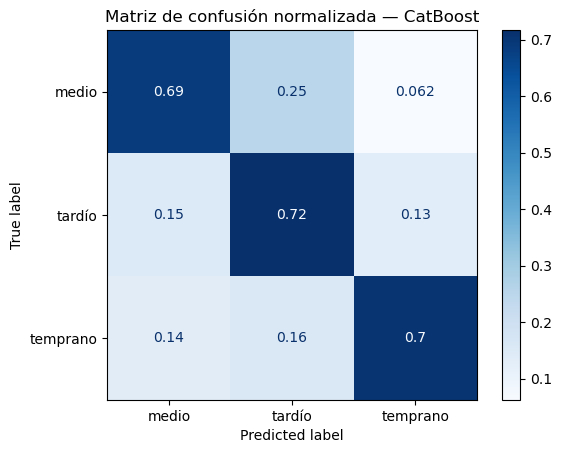

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Predicción
y_pred_cat = cat_model.predict(X_test)
y_pred_cat_labels = label_encoder.inverse_transform(y_pred_cat.flatten())

# Visualización normalizada
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_cat_labels,
    display_labels=label_encoder.classes_,
    cmap='Blues',
    normalize='true'
)
plt.title("Matriz de confusión normalizada — CatBoost")
plt.grid(False)
plt.show()


In [20]:
import pandas as pd

pd.DataFrame(resultados_modelos).sort_values(by='Accuracy', ascending=False)



,Modelo,Accuracy,Kappa,MCC
3,LightGBM,0.751938,0.522112,0.522716
4,CatBoost,0.709302,0.492392,0.501518
0,Random Forest,0.701550,0.406170,0.407665
2,K-Nearest Neighbors,0.639535,0.212278,0.222960
1,Decision Tree,0.538760,0.283099,0.309590


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Codificación de clases
label_mapping = {'inicio': 0, 'pico': 1, 'tardío': 2}
full_df['label_encoded'] = full_df['label'].map(label_mapping)

# Split por jugador
jugadores = full_df['Player_ID'].unique()
train_ids, test_ids = train_test_split(jugadores, test_size=0.2, random_state=42)

train_df = full_df[full_df['Player_ID'].isin(train_ids)]
test_df = full_df[full_df['Player_ID'].isin(test_ids)]

X_train = train_df[['inicio', 'pico', 'tardío']]
X_test = test_df[['inicio', 'pico', 'tardío']]
y_train = train_df['label_encoded']
y_test = test_df['label_encoded']

# Calcular pesos de clase
clases = [0, 1, 2]
pesos = compute_class_weight(class_weight='balanced', classes=clases, y=y_train)
pesos_dict = dict(zip(clases, pesos))

# Modelos
modelos = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42, class_weights=pesos_dict),
    "LightGBM": LGBMClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Evaluación
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"{nombre} → Accuracy: {acc:.3f}, Kappa: {kappa:.3f}, MCC: {mcc:.3f}")


NameError: name 'full_df' is not defined